In [1]:
import os
import sys
import numpy as np
import statsmodels.formula.api as smf
import statsmodels.api as sm
import pandas as pd

/Users/eduardomorenoortiz/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/Users/eduardomorenoortiz/anaconda3/lib/python3.7/site-packages/statsmodels/compat/pandas.py:23: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  data_klasses = (pandas.Series, pandas.DataFrame, pandas.Panel)


In [2]:
# Importar funciones de utils
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path+"/utils")

from utils import *

## Introducción

La obtención de probabilidades de incumplimiento es una parte fundamental en la toma de decisiones en las instituciones de crédito. La **probabilidad de incumplimiento** se define en general como la probabilidad de que un acreditado no cumpla con las obligaciones de su crédito durante 90 días o más. Generalmente se cree que la probabilidad de incumplimiento es una cantidad que puede ser tomada como una etiqueta y que esa misma etiqueta puede usarse para definir tasas de productos (*pricing*), análisis temporal o credit scoring. En este trabajo se mostrará una metodología que lleva a cabo una trasnformación de variables para mejorar el ajuste de un modelo de regresión logística. 

Para la obtención de los modelos se resolverá un **problema optimización convexo**.


### Datos:

Se utilizará la información de 60 trimestres de 5,000 créditos hipotecarios de Estados Unidos tomada de portafolios bursatilizados (RMBSs) a partir del año 2000 hasta 2015. El proveedor de la base es la instutición estadounidense [**International Financial Reasearch**](http://www.internationalfinancialresearch.org/). Cabe mencionar, que se  tiene acceso a ella por la adquisición del libro *Deep Credit Risk de Daniel Rosch y Harald Scheule*, el cual es la principal fuente de este proyecto.

A continuación, se enunciará y describirán las variables:

Dentro de la base de datos cada observación (*renglón*) corresponde a un préstamo otorgado por la institución hipotecaria.

1. *id*.- clave única por respondiente, dado que los préstamos se otorgan por distintos periodos de tiempo, el valor de esta variable se repite por varios préstamos (*renglones*).

1. *time*.- periodo observado identificado como trimestres deade el año $2000$ hasta $2015$, de tal manera que, $1$ corresponde al primer trimestre del año $2000$, $2$ al segundo trimestre del año $2000$, ...

1. *orig_time*.- trimestre en el que se otorgó el crédito. Si se otorgó previo al 2000, el número es negativo.

1. *first_time*.- trimestre en el que aparece el crédito se da de alta a la base de datos.

1. *mat_time*.- plazo del crédito (las unidades son trimestres).

1. *res_time*.- trimestre en el que se recuperó la vivienda.

1. *balance_time*.- saldo del respondiente al trimestre de observación. La unidad de medición son dólares americanos.

1. *LTV_time*.- Loan to Value a la originación (endeudamiento de un activo en relación con su valor real y actual). Para obtener una descripción más detallada se recomienda visitar el siguiente [link](https://www.ilpabogados.com/que-es-el-loan-to-value-ltv-y-por-que-es-relevante/). La unidad de medición son dólares americanos.

1. *interest_rate_time*.- tasa de interés en el trimestre correspondiente.

1. *rate_time*.- tasa libre de riesgo en el trimestre correspondiente.

1. *hpi_time*.- índice de precios de casas en el trimestre correspondiente.

1. *gdp_time*.- tasa de crecimiento del PIB en el trimestre correspondiente.

1. *uer_time*.- tasa de desempleo del trimestre correspondiente.

1. *REtype_CO_orig_time*.- identificador de condominio (condominio 1, en otro caso 0)

1. *REtype_PU_orig_time*.- identificador de desarrollo urbano (desarrollo urbano 1, en otro caso 0)

1. *REtype_SF_orig_time*.- identificador de vivienda familia unitaria (vivienda para una sola familia 1, en otro caso 0)

1. *investor_orig_time*.- identificador de  desarrollador (la casa fue construía por un desarrollador 1, en otro caso 0)

1. *balance_orig_time*.- monto del préstamo otorgado, las unidades de medición son dólares americanos.

1. *FICO_orig_time*.- [FICO score](https://www.ficoscore.com/ficoscore/pdf/Understanding-FICO-Scores-SPANISH.pdf) en el momento de originar el préstamo.

1. *LTV_orig_time*.- Loan to Value al momento de la originación del préstamo (las unidades de medición son dólares americanos).

1. *Interest_Rate_orig_time*.- tasa de interés del préstamo otorgado en el momento de la originación.

1. *state_orig_time*.- Estado de la unión americana donde se encuentra la vivienda.

1. *hpi_orig_time*.- índice de precios de casa al momento de la originación.

1. *default_time*.- indicadora de incumplimiento de pago (no se cumplió con la obligación de pagar el préstamo dado el trimestre correspondiente 1, en otro caso 0).

1. *payoff_time*.- indicadora de liquidación (liquidación 1, en otro caso 0).

1. *status_time*.- variable categórica con 3 niveles: 1 préstamo se declaró en default (no se cumplió con la obligación de pagarlo), 2 (se cumplió con la obligación de pagar), 0 en otro caso.

1. *lgd_time*.- [Loss given default](https://www.investopedia.com/terms/l/lossgivendefault.asp#:~:text=Loss%20given%20default%20(LGD)%20is,at%20the%20time%20of%20default.) o severidad al momento del default, las unidades de medición son dólares americanos.

1. *recovery_res*.- suma de los flujos recibidos durante el periodo de resolución, las unidades de medición son dólares americanos o bien, es el monto de  dinero que se recupera por adjudicar o quitar un inmueble.

## Fórmulación matemática del problema de optimización convexa

Con el objetivo de obtener probabilidades (cumplen con los [axiomas de Kolmogorov](https://es.wikipedia.org/wiki/Axiomas_de_probabilidad#:~:text=Los%20axiomas%20de%20probabilidad%20son,formulados%20por%20Kolmog%C3%B3rov%20en%201933.)  ) se utiliza la regresión logística, que implícitamente hace mención a la función sigmoide $\sigma: \mathbb{R} \rightarrow \mathbb{R}$, que tiene la siguiente regla de correspondencia:

$$ \sigma(x) = \frac{1}{1+exp(-x)} $$

En este proyecto, se buscará identificar si un préstamo no cumplirá con sus oblicaciones (no pagar/default) o sí las cumplirá, para ello se identifica las siguientes 2 clases:

* $C_1$: el préstamo es catalogado como default (no cumple con las obligaciones de pago)
* $C_0$: el préstamo es catalogado como no default (sí cumple con las obligaciones de pago)

Así pues, utilizando la función sigmoide estimaremos la probabilidad de pertenecer a la clase $C_1$ dado una serie de métricas $x$:

$$ \mathbb{P}[C_1|x] = \sigma(a), \text{ para alguna } a \in \mathbb{R} $$


Utilizando el [Teorema de Bayes](https://es.wikipedia.org/wiki/Teorema_de_Bayes) es posible llegar al siguiente resultado:

$$ \mathbb{P}[C_1|x] = \frac{ \mathbb{P}[x|C_1] \mathbb{P}[C_1]  } { \mathbb{P}[x|C_1] \mathbb{P}[C_1] + \mathbb{P}[x|C_0] \mathbb{P}[C_0] } = \frac{1} {1 + \frac{ \mathbb{P}[x|C_1] \mathbb{P}[C_1] }{ \mathbb{P}[x|C_0] \mathbb{P}[C_0] } } = \sigma(a) = \frac{1}{1+exp(-a)} $$


Por lo tanto,

$$ a(x) = log( \frac{ \mathbb{P}[x|C_1] \mathbb{P}[C_1] }{ \mathbb{P}[x|C_0] \mathbb{P}[C_0] } ) $$



El modelo de regresión logística (para $2$ clases) toma base de un modelo lineal en sus parámetros $\beta \in \mathbb{R}^n$ (donde $n$ indica la cantidad de variables/métricas a medir). Se añade un parámetro adicional $\beta_0$, por lo que el modelo tiene la siguiente forma:

$$ \beta^Tx + \beta_0= a(x|\beta, \beta_0) = log( \frac{ \mathbb{P}[C_1|x]  }{ \mathbb{P}[C_0|x]  } )  $$

Si $y$ es tomada como variable de respuesta, entonces se obtiene que está en función de $x \in \mathbb{R}^{n+1}$ dado el vector $\beta_0, \beta$. La regla de correspondencia es la siguiente:

$$ \mathbb{P}[C_1|x] = y(x | \beta_0, \beta) = \frac{ 1 } {1+exp(-(\beta_0 + \beta^Tx)) }  $$


En donde, la variable de optimización es $(\beta_0, \beta) \in \mathbb{R}^{n+1}$

Para el ajuste de los parámetros se utiliza la [metodología estudiada en el curso](https://itam-ds.github.io/analisis-numerico-computo-cientifico/III.optimizacion_convexa/3.3/Ejemplos_problemas_UCO_e_intro_CIEO_y_PI.html#como-se-ajustan-los-parametros-del-modelo-por-regresion-logistica-de-dos-clases), que se basa en maximizar la [función de verosimilitud](https://es.wikipedia.org/wiki/Funci%C3%B3n_de_verosimilitud#:~:text=En%20estad%C3%ADstica%2C%20la%20funci%C3%B3n%20de,de%20un%20conjunto%20de%20observaciones.), que es equivalente a minimizar la función log-verosimilitud, el cual es equivalente a minimizar la [devianza](https://en.wikipedia.org/wiki/Deviance_(statistics)):

$$ \large \text{min}_{\beta_0,\beta_1 \in \mathbb{R}^{n+1}} D(\beta_0, \beta|x) = -2 l(\beta_0, \beta|x) = \sum_{i=1}^m \text{log}( 1 + exp( (\beta_0,\beta )^Tx_i ) ) -\hat{y}_i(\beta_0,\beta )^Tx_i $$

En las notas del curso, se demuestra que la Hessiana de la devianza es una matriz simétrica semidefinida positiva y por tanto es una función convexa. Por lo que, en este proyecto se resolverá un **problema optimización (minimización) convexa.**

Este estudio minusioso de la función sigmoide y desarrollo matemático fue tomado del libro de [Optimización](https://itam-ds.github.io/analisis-numerico-computo-cientifico/README.html) cuyo autor es el profesor **Erick Moreno**.

### Lectura y preparación de datos

In [3]:
df = pd.read_csv('../data/data_t_final.csv')

In [4]:
df.head(5)

,id,time,orig_time,first_time,mat_time,res_time,balance_time,LTV_time,interest_rate_time,rate_time,...,FICO_orig_time,LTV_orig_time,Interest_Rate_orig_time,state_orig_time,hpi_orig_time,default_time,payoff_time,status_time,lgd_time,recovery_res
0,4,25,-2,25,119,NaN,61031.10,33.911009,10.500,5.9,...,587,81.8,10.5,KY,97.99,0,0,0,NaN,NaN
1,4,26,-2,25,119,NaN,60882.42,34.007232,10.500,5.9,...,587,81.8,10.5,KY,97.99,0,0,0,NaN,NaN
2,4,27,-2,25,119,NaN,60729.80,34.335349,10.500,5.9,...,587,81.8,10.5,KY,97.99,0,0,0,NaN,NaN
3,4,28,-2,25,119,NaN,60576.14,34.672545,10.875,5.9,...,587,81.8,10.5,KY,97.99,0,0,0,NaN,NaN
4,4,29,-2,25,119,NaN,60424.39,34.951639,10.875,5.9,...,587,81.8,10.5,KY,97.99,0,0,0,NaN,NaN


In [5]:
data = df.dropna(subset=['time', 'default_time','LTV_time', 'FICO_orig_time']).copy()

### WOE, IV

El [*WOE*](https://www.listendata.com/2015/03/weight-of-evidence-woe-and-information.html#What-is-Weight-of-Evidence-WOE-), acrónimo de Weight of Evidente puede llegar a ser confuso al inicio, pues no es un término muy conocido, sin embargo, su sencillez (en cuanto a la intuición) busca ser sencilla:

* Es una medida de separación entre "buenos clientes" y "malos clientes", siendo los buenos clientes aquellos que sí cumplen con sus oblicaciones de pagos y los malos clientes aquellos que no cumplen, dichos pagos no cumplidos son catalogados como préstamos que caen en *default*.

Su fórmula es la siguiente:

$$ \text{WOE} = \text{ln} \left( \frac{\% \mathcal{D}}{\% \mathcal{N_D}} \right)$$

En donde $\% \mathcal{D}$ corresponde a la fracción de préstamos catalogados como *default* (en este proyecto catologados con $1$ en la variable `default_time`). Mientras que $\% \mathcal{N_D}$ el complemento de la fracción anterior.

Para el [*IV*](https://www.listendata.com/2015/03/weight-of-evidence-woe-and-information.html#What-is-Information-Value-IV-), acrónimo de Information of Value, es una técnica para medir la importancia de las variables en modelos predictivos, la cual, nos ayudará a elegir aquellas variables con mayor poder predictivo. La fórmula es la siguiente:

$$ \text{IV} = \sum_{i=1}^n \text{WOE}_i*(\% \mathcal{N_D} - \% \mathcal{D})$$


Para este cómputo solamente se toman en cuenta las variables que son originadas al momento de efectuarse un préstamo.

A continuación seleccionaremos las variables que se poseen al momento de la originación de un préstamo, dichas variables son las siguientes:
* `id`
* `REtype_CO_orig_time`
* `REtype_PU_orig_time`
* `REtype_SF_orig_time`
* `investor_orig_time`
* `balance_orig_time`
* `FICO_orig_time`
* `LTV_orig_time`
* `Interest_Rate_orig_time`
* `state_orig_time`
* `hpi_orig_time`
* `default_time`

Cabe mencionar que la **variable dependiente** es `default_time`

In [6]:
data2 = data[["id","REtype_CO_orig_time","REtype_PU_orig_time","REtype_SF_orig_time",
              "investor_orig_time",
              "balance_orig_time",
              "FICO_orig_time",
              "LTV_orig_time",
              "Interest_Rate_orig_time",
              "state_orig_time",
              "hpi_orig_time",
              "default_time"]]

Seleccionamos los préstamos que fueron catalogados como *default*, es decir, que no cumplieron con la oblicagación de pago.

In [7]:
data_default = data2[(data2.default_time == 1)]

Ahora los que no cayeron en *default*

In [8]:
data_no_default_aux = data2[~data2.id.isin(data_default.id.values)]
data_no_default = data_no_default_aux.drop_duplicates(subset = ["id"])

Y por último juntamos ambas particiones, esto con el fin de tener ordenada la base de datos en relación a la variable dependiente.

In [9]:
data_score = data_default.append(data_no_default)

### Cálculo Weight of **Evidence** (*WOE*) y **IV** (*IV*)

A continuación se hará uso de la función `woe` que calcula el **WOE** y el **IV**, dicha función se encuentra dentro de la carpeta **utils**

In [10]:
data_score, outputIV1 = woe(data_in = data_score, target='default_time', variable = 'balance_orig_time', 
                            bins=5, binning = 'True')
data_score, outputIV2 = woe(data_in = data_score, target='default_time', variable = 'FICO_orig_time', 
                            bins=5, binning = 'True')
data_score, outputIV3 = woe(data_in = data_score, target='default_time', variable = 'LTV_orig_time', 
                            bins=5, binning = 'True')
data_score, outputIV4 = woe(data_in = data_score, target='default_time', variable = 'Interest_Rate_orig_time', 
                            bins=5, binning = 'True')
data_score, outputIV5 = woe(data_in = data_score, target='default_time', variable = 'hpi_orig_time', 
                            bins=5, binning = 'True')
data_score, outputIV6 = woe(data_in = data_score, target='default_time', variable = 'REtype_CO_orig_time', 
                            bins=5, binning = 'False')
data_score, outputIV7 = woe(data_in = data_score, target='default_time', variable = 'REtype_PU_orig_time', 
                            bins=5, binning = 'False')
data_score, outputIV8 = woe(data_in = data_score, target='default_time', variable = 'REtype_SF_orig_time', 
                            bins=5, binning = 'False')

Los **IV** previamente calculados son:

In [11]:
print(pd.concat([outputIV1, outputIV2, outputIV3, outputIV4, outputIV5, outputIV6, outputIV7, outputIV8]).\
      round(decimals=4))

                      name      IV
0        balance_orig_time  0.0098
0           FICO_orig_time  0.0899
0            LTV_orig_time  0.0744
0  Interest_Rate_orig_time  0.1238
0            hpi_orig_time  0.5513
0      REtype_CO_orig_time  0.0000
0      REtype_PU_orig_time  0.0000
0      REtype_SF_orig_time  0.0000


Cabe mencionar que para la gran mayoría de las variables de interés el **IV** es muy bajo a excepción de:
1. `hpi_orig_time`
1. `Interest_Rate_orig_time`
1. `LTV_orig_time`
1. `FICO_orig_time`

Se posee la siguiente *heurística* (documentación en el libro de referencia y en la siguiente [página](https://www.listendata.com/2015/03/weight-of-evidence-woe-and-information.html#What-is-Information-Value-IV-)) para la siguiente clasificación del **IV** en relación a su poder predictivo:

* **Muy bajo** si $\text{IV} \in (0, 0.02]$
* **Poder débil** si $\text{IV} \in (0.02, 0.1]$
* **Poder moderado** si $\text{IV} \in (0.1, 0.3]$
* **Fuerte** si $\text{IV} > 0.3$

Por lo que, concluímos que:
1. `hpi_orig_time`.- tiene **fuerte poder** predictivo
1. `Interest_Rate_orig_time`.- tiene **poder moderado** predictivo
1. `LTV_orig_time`.- tiene **poder débil** predictivo
1. `FICO_orig_time`.- tiene **poder débil** predictivo

Para las demás variables, el poder predictivo es **muy bajo**.

Para el análisis, se excluirán las variables que tengan un **muy bajo** poder predictivo, pues no ayudarán a completar el objetivo de este estudio.

### Obtención del modelo y del respectivo score

Para esta parte se utilizará un modelo de **regresión logística** tomando en cuanta las variables que más ayudan a clasificar si un préstamo es default o no. Estas variables deben ser las que son originadas al momento de efectuar el préstamo (`orig_time`), pues queremos saber si dicho préstamo será o no default. Además, se utilizará la evidencia de dicha variable para predecir si el préstamo es o no default, los cuales ya fueron calculados previamente.

* *FICO-WOE*
* *LTV-WOE*
* *Tasa de interés (interest rate)*
* *HPI*

Selección de features (variables) para el modelo

In [12]:
data_score_regresion = data_score[["id","default_time", 
                         "FICO_orig_time_WOE", 
                         "LTV_orig_time_WOE", 
                         "Interest_Rate_orig_time_WOE", 
                         "hpi_orig_time_WOE"]]

In [13]:
variables = ["default_time", 
             "FICO_orig_time_WOE", "LTV_orig_time_WOE", "Interest_Rate_orig_time_WOE", "hpi_orig_time_WOE"]

Obtención del modelo mediante la optimización del problema convexo (minimización de la devianza)

In [14]:
pronostico, model = estim_prob(data_score_regresion, variables)

4996
Evaluación de valor óptimo al resolver problema de optimización 5406.228464817561


In [15]:
for i in range(1,5):
    print('Variable: ', variables[i], ' - \tCoeficiente estimado: ', model[i])

Variable:  FICO_orig_time_WOE  - 	Coeficiente estimado:  0.9174101028121974
Variable:  LTV_orig_time_WOE  - 	Coeficiente estimado:  0.9428885669616126
Variable:  Interest_Rate_orig_time_WOE  - 	Coeficiente estimado:  0.4766783164336945
Variable:  hpi_orig_time_WOE  - 	Coeficiente estimado:  0.9741406048262965


In [16]:
data_time = pd.merge(data_score_regresion, data['time'], left_index=True, right_index=True)
PD_logit_model = pd.DataFrame(pronostico, columns=['PD_logit_model'])
data2 = pd.merge(data_time[['default_time','time']],
                 PD_logit_model, right_index=True, left_index=True)

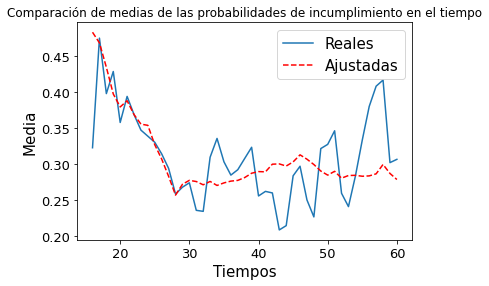

In [17]:
grafica_medias(data2.PD_logit_model, data2.default_time, data2.time, continuous=False)

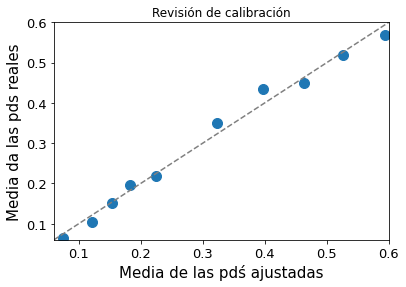

In [18]:
grafica_ajuste(data2.PD_logit_model, data2.default_time, data2.time, continuous=False)

Obtención del modelo utilizando la librería [smf](https://www.statsmodels.org/stable/generated/statsmodels.formula.api.ols.html) para comparar los parámetros del modelo obtenido

In [19]:
model_score = smf.glm('default_time ~ FICO_orig_time_WOE + LTV_orig_time_WOE + \
                      Interest_Rate_orig_time_WOE + hpi_orig_time_WOE', 
                      family = sm.families.Binomial(), data = data_score_regresion).fit()

A continuación se analizarán los coeficientes y *p-value* de cada feature obtenidos del modelo.

In [20]:
print(model_score.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:           default_time   No. Observations:                 4996
Model:                            GLM   Df Residuals:                     4991
Model Family:                Binomial   Df Model:                            4
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2703.1
Date:                Mon, 07 Dec 2020   Deviance:                       5406.2
Time:                        19:20:12   Pearson chi2:                 4.92e+03
No. Iterations:                     5                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept         

Se calculará el error de la aproximación utilizando el modelo obtenido con el módulo `glm` como base:

In [21]:
print('Error de estimación: ', np.linalg.norm( model_score.params - model))

Error de estimación:  2.998017780386756e-07


Se tiene una aproximación de 7 cifras, por lo que se concluye que el error de es pequeño y se obtiene una buena aproximación.

### Resultados

* Los parámetros tienen un coeficiente positivo, por los que incrementos en cada una de ellos tendrán un efecto (no directamente proporcional) positivo en la estimación de la probabilidad para determinar si un préstamo será catalogado como default o no. 

* Complementando nuestro análisis con el análisis obtenido con la paquetería **glm**, podemos observar que todas las variables son significativas, es decir, el *valor-p* de cada una de las variables es pequeño, lo cual nos indica que en conjunto todas las variables ayudan a explicar la varianza de la variable dependiente. Es decir, aportan información para la clasificación que se busca realizar.